## Machine Learning on Hospital Readmission and Home Health Care Quality


**Choice of Data: **<br>
After further review of the nongrouped data, it was determined that there is no other way to combine the Hospital Radmission (Readmit) data with the Home Health Care (HHC) data other than by state.  Future analysis could be done by grouping HHC agencies and hosptials by zip code or city.  Said data points were available in the HHC data, but not in the Readmit data and would need to be gathered elsewhere. <br><br>
**Choice of Method:**<br>
Unsupervised learning was chosen as the best form of machine learning method to apply.  The probelm we are trying to solve is one that is reviewing connections to predict outcomes rather than label prediction.  As such, unsupervised machine learning was chosen to see if the collected data had any interesting connections that were not obvious through EDA.  My intuition says KMeans may be the best tool for the job as we can tune the hyperparameters for a better model.  However, numerous other methods may be tried as well.

In [1]:
# Importing Necessary Tools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

In [2]:
# Import Cleaned DataFrame
df = pd.read_csv('readmit_hhc_final.csv', index_col=0)
df.head()

,state,hospital_count,readmission_ratio,discharges,predicted_rate,expected_rate,readmissions,excessive_count,star_rating,timeliness,...,breathing_buff,healing_buff,oral_rx_buff,hospital_admit,urgent_noadmit,pos_prof_report,pos_communicate_report,pos_treatment_ed_report,nine_to_ten_rate,would_recommend
0,AK,8,0.969563,5019.0,530.2,548.7,606.0,11,2.5,76.7,...,58.8,80.4,45.8,14.2,17.3,89,85,81,82,81
1,AL,85,1.017475,95303.0,5351.5,5308.2,15305.0,188,3.5,94.3,...,74.5,91.3,62.5,17.5,12.2,91,89,87,89,84
2,AR,45,1.032275,61703.0,2973.3,2879.7,9965.0,127,3.0,94.3,...,71.7,91.8,61.1,17.4,13.4,90,87,86,87,83
3,AZ,63,0.988116,76353.0,3930.2,3990.3,10290.0,104,3.5,93.4,...,71.3,85.8,55.2,14.9,13.5,87,84,80,81,75
4,CA,297,1.000689,303151.0,19823.2,19733.7,49252.0,580,3.5,90.3,...,71.9,91.9,55.5,14.8,11.9,85,83,82,80,74


Based on previous exploration not shown here, it appears the number of hospitals reviewed in a state and the number of excessive readmissions in a state played a strong role in clustering.  As we are interested in quality ratings and readmission ratios /counts let's remove the following columns:<br><br>
Hospital Count<br>
Discharges<br>
Predicted Rate<br>
Expected Rate<br>
Readmissions

In [3]:
drop_cols = ['hospital_count','discharges','predicted_rate','expected_rate']
for col in drop_cols:
    df= df.drop(col, axis=1)

In [4]:
# Grab arrays of States and Readmission Ratios for Potential Labels
states = np.array(df.state)
re_ratio = np.array(df.readmission_ratio)


# Create Matrix of Numeric Data
matrix = df.drop('state', axis=1)
matrix = np.matrix(matrix)

There are a lot of dimensions to play with here so I would like to run a PCA variance test to get a good idea on the amount of PCA features.  I will be using the Standard Scaler to scale the features as their ranges vary quite heavily.

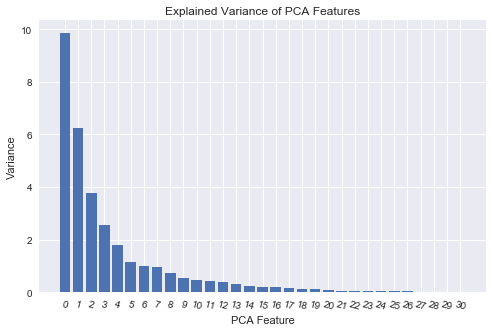

In [5]:
# Initialize model and create pipeline
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)

# Fit martix to pipeline
pipeline.fit(matrix)

# Plotting the explained variances
sns.set()
plt.subplots(0,figsize=(8,5))
features= range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('Explained Variance of PCA Features')
plt.xticks(features, rotation=-15)

plt.show()

After observing this Explaine Variance Plot, I feel the best feature count to use would be as the explained variance begins to taper off after feature number 4. <br>
***
Now let's select the hyperparameter K for our KMeans model!

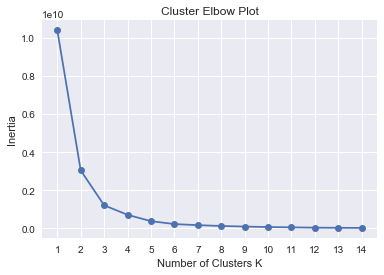

In [6]:
# Initialize Model into pipeline
kmean = KMeans()
kmean_pipeline = make_pipeline(scaler,kmean)

# Initialize ks to cycle through and inertias to calculate for elbow plot.
ks = range(1,15)
inertias = []

# Iterating through ks and applying inertias to list
for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(matrix)
    inertias.append(model.inertia_)

# Plotting ks and inertias to create Elbow Plot
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Cluster Elbow Plot')
plt.xticks(ks)
plt.show()
    

The elbow appears to be located at a K of 2 or 3.  Let's explore more by checking out the cluster counts using this 'best' K.

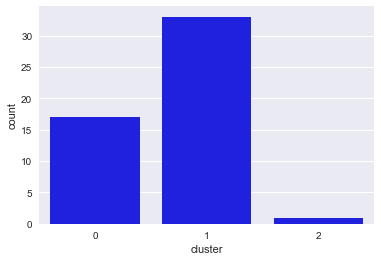

In [7]:
# Create bestK model and update pipeline with bestK
bestK = KMeans(n_clusters=3, random_state=42)
kmean_pipeline= make_pipeline(scaler, bestK)

# Fit Data and add prediction to DataFrame
df['cluster'] = kmean_pipeline.fit_predict(matrix)

# Create Value Counts DataFrame counting the number of each cluster.  Rename columns for readability.
xs = df.cluster.value_counts().reset_index()
xs.columns=('cluster','count')

# Plot bar plot
sns.barplot('cluster', 'count', data=xs, color='b')
plt.show()

Three clusters appear to be a fairly weak number of clusters.  Let's try 2 clusters!

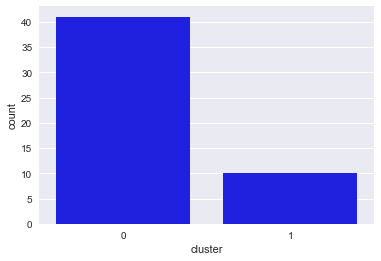

In [8]:
# Create bestK model and update pipeline with bestK
bestK = KMeans(n_clusters=2, random_state=42)
kmean_pipeline= make_pipeline(scaler, bestK)

# Fit Data and add prediction to DataFrame
df['cluster'] = kmean_pipeline.fit_predict(matrix)

# Create Value Counts DataFrame counting the number of each cluster.  Rename columns for readability.
xs = df.cluster.value_counts().reset_index()
xs.columns=('cluster','count')

# Plot bar plot
sns.barplot('cluster', 'count', data=xs, color='b')
plt.show()

Let's set up and plot the clusters using our best number of PCA features!

In [9]:
# Set PCA to 4 components
best_pca = PCA(n_components=4)

# Create Best PCA Pipeline
pca_pipeline = make_pipeline(scaler, best_pca)

# Create x and y columns then pull all columns into new DataFrame
df['x'] = pca_pipeline.fit_transform(matrix)[:,0]
df['y'] = pca_pipeline.fit_transform(matrix)[:,1]
new_df = df[['cluster','x','y']]
new_df.head()

,cluster,x,y
0,1,9.623950,-5.987501
1,0,-5.224645,0.550353
2,0,-3.255849,0.234227
3,0,1.041767,-0.423682
4,0,-0.027478,2.233595


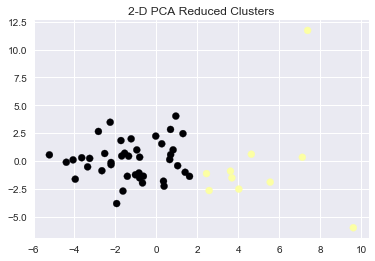

In [10]:
# Plot X and Y data of 5-D PCA Reduced Clusters
plt.scatter(new_df.x,new_df.y, c=new_df.cluster, cmap='inferno' )
plt.title('2-D PCA Reduced Clusters')
plt.show()

The black and yellow appear to be fairly distinct from one another.

In [11]:
df.head()

,state,readmission_ratio,readmissions,excessive_count,star_rating,timeliness,rx_ed,fall_risk,depression_check,flu_shot,...,hospital_admit,urgent_noadmit,pos_prof_report,pos_communicate_report,pos_treatment_ed_report,nine_to_ten_rate,would_recommend,cluster,x,y
0,AK,0.969563,606.0,11,2.5,76.7,94.5,99.4,93.9,64.7,...,14.2,17.3,89,85,81,82,81,1,9.623950,-5.987501
1,AL,1.017475,15305.0,188,3.5,94.3,97.8,99.6,98.4,72.4,...,17.5,12.2,91,89,87,89,84,0,-5.224645,0.550353
2,AR,1.032275,9965.0,127,3.0,94.3,95.9,99.5,98.6,75.0,...,17.4,13.4,90,87,86,87,83,0,-3.255849,0.234227
3,AZ,0.988116,10290.0,104,3.5,93.4,96.9,99.4,97.3,74.9,...,14.9,13.5,87,84,80,81,75,0,1.041767,-0.423682
4,CA,1.000689,49252.0,580,3.5,90.3,97.2,99.1,97.7,73.6,...,14.8,11.9,85,83,82,80,74,0,-0.027478,2.233595


In [12]:
# Group by cluster to get counts on Star Rating to see if there is a difference.
df.groupby('cluster').star_rating.value_counts()

cluster  star_rating
0        3.5            28
         3.0            13
1        3.0             9
         2.5             1
Name: star_rating, dtype: int64

In [13]:
df.groupby('cluster').readmission_ratio.value_counts()

cluster  readmission_ratio
0        0.914832             1
         0.927339             1
         0.931067             1
         0.932066             1
         0.949882             1
         0.951322             1
         0.953858             1
         0.954463             1
         0.955349             1
         0.965708             1
         0.972196             1
         0.974291             1
         0.979488             1
         0.979649             1
         0.988116             1
         0.996701             1
         0.996822             1
         0.997332             1
         0.998982             1
         0.999401             1
         1.000689             1
         1.002759             1
         1.003394             1
         1.003798             1
         1.003899             1
         1.007372             1
         1.009932             1
         1.010657             1
         1.012553             1
         1.015363             1
         1.01

In [14]:
df.groupby('cluster').flu_shot.value_counts()

cluster  flu_shot
0        76.8        3
         73.3        2
         74.2        2
         74.9        2
         76.3        2
         76.4        2
         77.8        2
         78.5        2
         63.9        1
         64.9        1
         67.2        1
         68.9        1
         70.3        1
         70.9        1
         71.8        1
         72.2        1
         72.4        1
         72.8        1
         72.9        1
         73.6        1
         74.3        1
         75.0        1
         75.5        1
         76.2        1
         76.6        1
         77.9        1
         79.0        1
         79.1        1
         79.6        1
         81.0        1
         81.9        1
         83.1        1
1        75.5        2
         64.7        1
         69.2        1
         69.4        1
         69.6        1
         70.8        1
         71.7        1
         78.0        1
         78.9        1
Name: flu_shot, dtype: int64

Overall it's fairly difficult to tell how these clusters are separated by individual numbers.  It might be a good ideal to round them into groups ie. 1 or 0 to indicate excessive readmission ratio, or 60-65, 65-70 ect. for the quality ratings measures.

In [18]:
df[df.cluster==0]

,state,readmission_ratio,readmissions,excessive_count,star_rating,timeliness,rx_ed,fall_risk,depression_check,flu_shot,...,hospital_admit,urgent_noadmit,pos_prof_report,pos_communicate_report,pos_treatment_ed_report,nine_to_ten_rate,would_recommend,cluster,x,y
1,AL,1.017475,15305.0,188,3.5,94.3,97.8,99.6,98.4,72.4,...,17.5,12.2,91,89,87,89,84,0,-5.224645,0.550353
2,AR,1.032275,9965.0,127,3.0,94.3,95.9,99.5,98.6,75.0,...,17.4,13.4,90,87,86,87,83,0,-3.255849,0.234227
3,AZ,0.988116,10290.0,104,3.5,93.4,96.9,99.4,97.3,74.9,...,14.9,13.5,87,84,80,81,75,0,1.041767,-0.423682
4,CA,1.000689,49252.0,580,3.5,90.3,97.2,99.1,97.7,73.6,...,14.8,11.9,85,83,82,80,74,0,-0.027478,2.233595
5,CO,0.955349,4483.0,37,3.5,93.0,94.9,99.3,97.0,79.0,...,15.4,14.4,87,84,82,82,76,0,0.819699,0.997563
8,DE,0.996822,3529.0,16,3.5,93.8,96.4,99.3,97.5,74.9,...,16.3,12.8,87,85,83,81,77,0,0.265715,1.541651
9,FL,1.032694,60967.0,547,3.5,95.2,96.0,99.4,98.0,68.9,...,15.9,10.6,89,85,82,85,79,0,-2.254424,3.476921
10,GA,1.007372,20261.0,204,3.5,90.4,96.5,99.2,98.4,71.8,...,16.6,14.3,89,86,83,85,80,0,-1.354176,0.433993
12,IA,0.965708,6908.0,56,3.0,94.3,95.9,99.4,98.5,77.9,...,17.0,14.2,88,86,86,85,80,0,-0.631959,-1.365584
13,ID,0.927339,1529.0,7,3.5,94.1,96.9,99.7,98.8,76.3,...,14.2,14.3,88,85,81,85,81,0,-1.690375,0.449895


I believe the small amount of observations (51 total) may be playing a role in the weak group clustering above.  It may be best to try and scrape the zip codes and add them to the Readmission Ratio data.  Instead of saving this for a future analysis, I now believe it is best to increase the number of observations for the present project.  Furthermore, an increase in observations will test the reliability of my initial EDA.